# SINVAD Experiments - Research Question 1 (Plausibility)

This notebook provides outlines on experiments performed for RQ1 (Section 5.2 of paper). It contains code that generates results similar to those presented in Figure 2-6 of the paper. The reason I use Jupyter notebooks for presentation is primarily because it interactively shows the results of small experiments in a way that helps understanding.

## Step 0. Preparation

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import scipy
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sa.model import MnistClassifier, EasyClassifier
from vae.model import VAE

In [2]:
img_size = 28*28*1
torch.no_grad()
vae_model_path = './vae/models/MNIST_EnD.pth'
classifier_model_path = './sa/models/MNIST_conv_classifier.pth'

In [3]:
vae = VAE(img_size = 28*28, h_dim = 1600, z_dim = 400)
vae.load_state_dict(torch.load(vae_model_path))
vae.eval()
vae.cuda()

classifier = MnistClassifier(img_size = img_size)
classifier.load_state_dict(torch.load(classifier_model_path))
classifier.eval()
classifier.cuda()
print("models loaded")

models loaded


In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
print("Data loader ready")

Data loader ready


### Preprocessing to calculate Surprise Adequacy

In [5]:
sa_layer = 7
layer_dim = 512

In [6]:
# get KDE used for LSA calculation
all_ats = torch.zeros(0, layer_dim)
for i, (x, x_class) in enumerate(train_data_loader):
    x = x.cuda()
    ats = classifier.at_by_layer(x, sa_layer).detach()
    all_ats = torch.cat([all_ats, ats.cpu()], dim=0)
all_ats = all_ats.transpose(0, 1).numpy()
rem_cols = np.std(all_ats, axis=1) < 0.6
ref_all_ats = all_ats[~rem_cols]
ref_all_ats = ref_all_ats[:100]
print(ref_all_ats.shape)
our_kde = gaussian_kde(ref_all_ats)

def calc_lsa(at, kde):
    return -kde.logpdf(at)

def calc_img_lsa(img):
    pr_at = classifier.at_by_layer(img, sa_layer).detach()
#     pr_at = classifier.up2lyr2(img).detach()
    pr_at = pr_at.cpu().numpy().transpose()
    pr_at = pr_at[~rem_cols][:100]
    return calc_lsa(pr_at, our_kde)

(100, 60000)


In [7]:
lsas = []
for i, (x, x_class) in enumerate(test_data_loader):
    if i > 100: break
    lsas.append(calc_img_lsa(x.cuda()))
#     print(i)
print(f'maximum lsa in test dataset: {max(lsas)}')
print(f'minimum lsa in test dataset: {min(lsas)}')

maximum lsa in test dataset: [176.2396936]
minimum lsa in test dataset: [110.81289312]


## Step 1. Optimizing Images

Images are optimized to have a certain surprise adequacy value. The point of this experiment is to show that the choice of representation is influential in how coherent the final result is, motivating the use of VAEs in SINVAD. The code in this step corresponds to Figure 2 in the paper. 

### Optimizing with raw pixel representation

Original Random Image


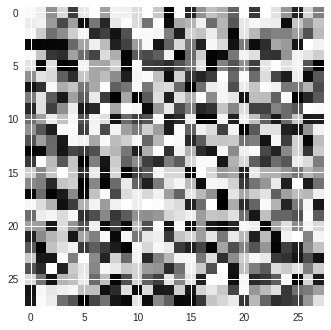

In [8]:
# generate random pixel image
print('Original Random Image')
pix_rand_img = np.random.randn(28, 28)
plt.imshow(np.tanh(pix_rand_img))

In [9]:
pix_rand_img_tensor = torch.Tensor(pix_rand_img).cuda().view(-1, 1, 28, 28)
pr_at = classifier.at_by_layer(pix_rand_img_tensor, sa_layer).detach()
pr_at = pr_at.cpu().numpy().transpose()
pr_at = pr_at[~rem_cols][:100]
print('lsa of random image:', calc_lsa(pr_at, our_kde)[0])

lsa of random image: 404.1000781682092


In [10]:
# fitness function
def loss(sa, obj = -10):
    return abs(sa - obj)

In [11]:
# optimization (a form of hill climbing)
prev_sa = calc_img_lsa(pix_rand_img_tensor)
target_sa = 111
prev_loss = loss(prev_sa, target_sa)
opt_img = pix_rand_img_tensor.clone()

opt_epoch_num = 3
last_diff_prop = 2.
for e_idx in range(opt_epoch_num):
    update_num = 0
    print(f'-----epoch {e_idx} start-----')
    for i in range(28):
        for j in range(28):
            img_copy = opt_img.clone()
            img_copy[:, :, i, j] = img_copy[:, :, i, j] + last_diff_prop*torch.randn(1).cuda()
            new_sa = calc_img_lsa(img_copy)
            new_loss = loss(new_sa, target_sa)
            if prev_loss > new_loss:
                opt_img = img_copy
                prev_loss = new_loss
                prev_sa = new_sa
                update_num += 1
                print('\r'*100, end='')
                print(f'new_sa: {new_sa[0]:.1f}', end='')
    print(f'\n# of updates: {update_num}')
    if (update_num == 0 or prev_loss < 0.01): break
    print(f'-----epoch {e_idx} over-----')
    last_diff_prop *= 0.5

-----epoch 0 start-----
new_sa: 123.9new_sa: 125.9
# of updates: 219
-----epoch 0 over-----
-----epoch 1 start-----
new_sa: 120.9
# of updates: 118
-----epoch 1 over-----
-----epoch 2 start-----
new_sa: 120.9
# of updates: 34
-----epoch 2 over-----


Target SA 111, Actual SA 120.9


(-0.5, 27.5, 27.5, -0.5)

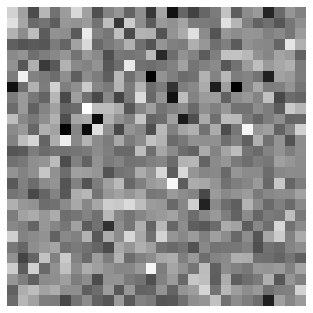

In [12]:
print(f'Target SA {target_sa}, Actual SA {new_sa[0]:.1f}')
plt.imshow(opt_img.view(28, 28).detach().cpu())
plt.axis('off')

### Optimizing with VAE latent space (SINVAD)

Original Random Image


/home/sungmin/Documents/dlTestGen/opensource-icse2020/osenv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


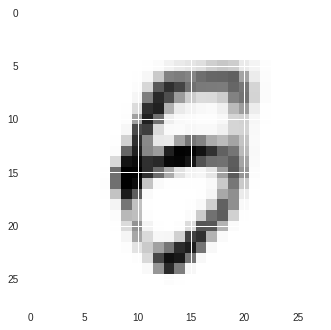

In [13]:
b_size = 1
rand_norm_v = torch.randn(b_size, 400).cuda()
vae_rand_imgs = vae.decode(rand_norm_v)
print('Original Random Image')
plt.imshow(vae_rand_imgs[0].view(1, 1, 28, 28)[0][0].detach().cpu())

In [14]:
# helper functions
def calc_z_lsa(z):
    vae_img = vae.decode(z).view(-1, 1, 28, 28)
    return calc_img_lsa(vae_img)

def loss(sa, obj = -10):
    return abs(sa - obj)

def z_to_img(z):
    return vae.decode(z).detach()

In [15]:
print('initial SA:', calc_z_lsa(rand_norm_v))

initial SA: [130.69508575]


In [16]:
# same optimization process as above
prev_sa = calc_z_lsa(rand_norm_v)
target_sa = 111
prev_loss = loss(prev_sa, target_sa)
opt_z = rand_norm_v.clone()
z_dim = 400

last_diff_prop = 5.
opt_epoch_num = 3
for e_idx in range(opt_epoch_num):
    last_epoch_z = opt_z
    update_num = 0
    print(f'-----epoch {e_idx} start-----')
    for i in range(z_dim):
        z_copy = opt_z.clone()
        z_copy[:, i] = z_copy[:, i] + last_diff_prop*torch.randn(1).cuda()
        new_sa = calc_z_lsa(z_copy)
        new_loss = loss(new_sa, obj=target_sa)
        if prev_loss > new_loss:
            opt_z = z_copy
            prev_loss = new_loss
            prev_sa = new_sa
            update_num += 1
            print('\r'*100, end='')
            print(f'new_sa: {new_sa[0]:.4f}', end='')
        if prev_loss < 0.01: break
    print(f'\n# of updates: {update_num}')
    print(f'change though opt: {torch.sum(torch.abs(last_epoch_z - opt_z))}')
    last_diff_prop = max(torch.sum(torch.abs(last_epoch_z - opt_z))/update_num, update_num/z_dim)
    if (update_num == 0 or prev_loss < 0.01): break

-----epoch 0 start-----
new_sa: 114.9333
# of updates: 124
change though opt: 387.4988708496094
-----epoch 1 start-----
new_sa: 112.9691
# of updates: 108
change though opt: 199.4506378173828
-----epoch 2 start-----
new_sa: 112.2821
# of updates: 133
change though opt: 149.5404052734375


Target SA 111, Actual SA 112.3


(-0.5, 27.5, 27.5, -0.5)

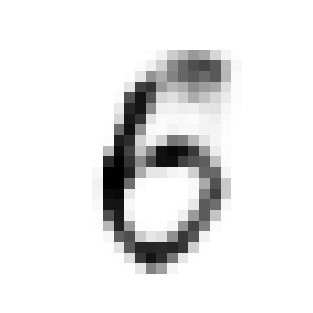

In [17]:
print(f'Target SA {target_sa}, Actual SA {new_sa[0]:.1f}')
plt.imshow(z_to_img(opt_z).view(28, 28).detach().cpu())
plt.axis('off')

## Step 2. PCA Projection

Using the PCA dimensionality reduction technique, we explore the activation trace space, and find that raw pixel optimized images are further from the training image activation trace distribution than those generated by SINVAD. This code corresponds to Figure 3 and 4 in the paper. 

In [18]:
# a linear classifier is used, for the convolutional classifier yields less clear PCA results.
pca_classifier = EasyClassifier(img_size = img_size, h_dim = 800)
pca_classifier.load_state_dict(torch.load('./sa/models/MNIST_classifier.pth'))
pca_classifier.eval()
pca_classifier.cuda()
print("models loaded")

models loaded


In [21]:
# prep
from sklearn.decomposition import PCA
import seaborn as sns

In [22]:
# get KDE used for LSA calculation
all_ats = torch.zeros(0, 800)
for i, (x, x_class) in enumerate(train_data_loader):
    x = x.cuda().view(-1, img_size)
    ats = pca_classifier.up2lyr2(x).detach()
    all_ats = torch.cat([all_ats, ats.cpu()], dim=0)
all_ats = all_ats.transpose(0, 1).numpy()
rem_cols = np.std(all_ats, axis=1) < 1
ref_all_ats = all_ats[~rem_cols]
our_kde = gaussian_kde(ref_all_ats)

def calc_lsa(at, kde):
    return -kde.logpdf(at)

In [23]:
# get activation trace by digit
digit_ats = [torch.zeros(0, 800) for _ in range(10)]
for i, (x, x_class) in enumerate(train_data_loader):
    x = x.cuda().view(-1, img_size)
    ats = pca_classifier.up2lyr2(x).detach()
    for d_idx in range(10):
        digit_at = ats[x_class == d_idx]
        digit_ats[d_idx] = torch.cat([digit_ats[d_idx], digit_at.cpu()], dim=0)

for d_idx in range(10):
    digit_ats[d_idx] = digit_ats[d_idx].numpy()[:, ~rem_cols]

[0.27149865 0.20220558]


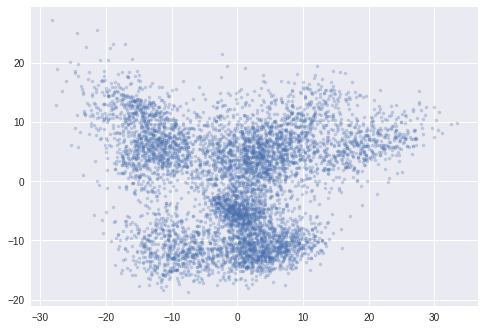

In [24]:
# get PCA of all train data ATs
X = ref_all_ats
pca = PCA(n_components = 2)
pca.fit(X.transpose())
print(pca.explained_variance_ratio_)
X = pca.transform(X.transpose())
red_X = X[np.random.binomial(1, 0.1, (X.shape[0],)).astype(bool)]
plt.plot(red_X[:, 0], red_X[:, 1], '.', alpha=0.3)

Legend: [(0, 'Navy'), (1, 'BlueViolet'), (2, 'Chocolate'), (3, 'Blue'), (4, 'Crimson'), (5, 'GreenYellow'), (6, 'HotPink'), (7, 'Teal'), (8, 'Maroon'), (9, 'Purple')]


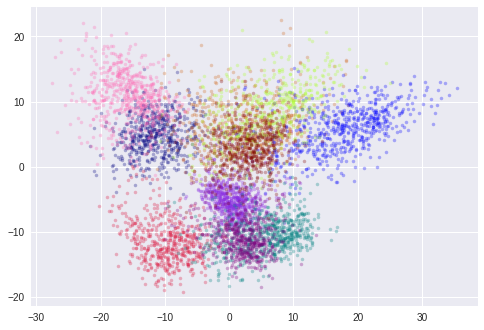

In [25]:
# Figure 3 - scatterplot of distribution with color (color from 0 to 9)
colors = ['Navy', 'BlueViolet', 'Chocolate', 'Blue', 'Crimson', 
          'GreenYellow', 'HotPink', 'Teal', 'Maroon', 'Purple']
for d_idx, c_name in enumerate(colors):
    d_data = pca.transform(digit_ats[d_idx][np.random.binomial(1, 0.1, (digit_ats[d_idx].shape[0],)).astype(bool)])
    x, y = d_data[:, 0], d_data[:, 1]
    plt.plot(x, y, ".", color=c_name, alpha=0.3)
# plt.show()
print('Legend:', list(enumerate(colors)))

/home/sungmin/Documents/dlTestGen/opensource-icse2020/osenv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


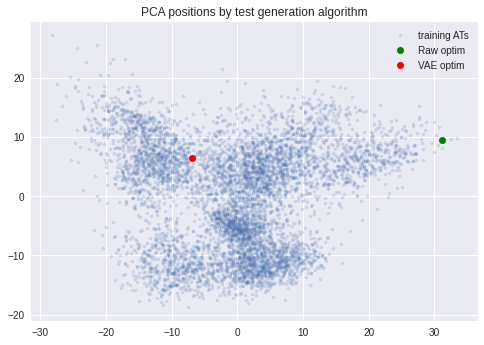

In [26]:
# Figure 4 - Placement of optimized images
# to add more points, add elements to opt_img_lst / vae_img_lst
opt_img_lst = [opt_img.view(28, 28)]
vae_img_lst = [z_to_img(opt_z).view(28, 28)]

raw_movement_tracker = np.zeros((0, red_X.shape[1]))
for img in opt_img_lst:
    raw_ats = pca_classifier.up2lyr2(img.view(-1, 28**2))
    raw_ats = raw_ats.detach().cpu().numpy()
    raw_ats = raw_ats[:, ~rem_cols]
    pca_raw_ats = pca.transform(raw_ats)
    raw_movement_tracker = np.vstack([raw_movement_tracker, pca_raw_ats])
vae_movement_tracker = np.zeros((0, red_X.shape[1]))
for img in vae_img_lst:
    vae_ats = pca_classifier.up2lyr2(img.view(-1, 28**2))
    vae_ats = vae_ats.detach().cpu().numpy()
    vae_ats = vae_ats[:, ~rem_cols]
    pca_vae_ats = pca.transform(vae_ats)
    vae_movement_tracker = np.vstack([vae_movement_tracker, pca_vae_ats])
plt.plot(red_X[:, 0], red_X[:, 1], '.', alpha=0.2, label='training ATs')
plt.plot(raw_movement_tracker[:, 0], raw_movement_tracker[:, 1], 'go', label='Raw optim')
plt.plot(vae_movement_tracker[:, 0], vae_movement_tracker[:, 1], 'ro', label='VAE optim')
plt.title('PCA positions by test generation algorithm')
plt.legend(loc="upper right")
plt.rc('font', size=22)

## Step 3. Interpolation

Using two randomly sampled images, we qualitatively observe the interpolation qualities of the representations. This code corresponds to Figure 5 in the paper. 

In [27]:
# sample a random pair of images
tc = (4, 9)
for i, (x, x_class) in enumerate(train_data_loader):
    x = x.cuda()
    img1 = x[0:1]
    img2 = x[1:2]
    if x_class[0] == tc[0] and x_class[1] == tc[1]:
        break

/home/sungmin/Documents/dlTestGen/opensource-icse2020/osenv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


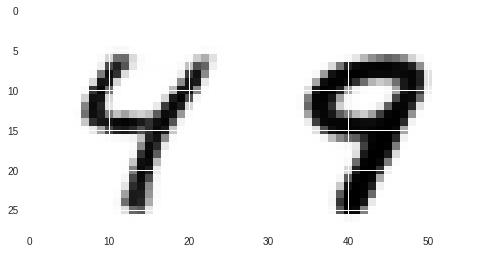

In [28]:
# get intermediate vectors, show reconstruction (without noise)
enc1, _ = vae.encode(img1.view(-1, img_size))
enc2, _ = vae.encode(img2.view(-1, img_size))
rec_img1 = vae.decode(enc1).view(1, 1, 28, 28)
rec_img2 = vae.decode(enc2).view(1, 1, 28, 28)
showoff_img = torch.cat([rec_img1, rec_img2], dim=3)
plt.imshow(showoff_img[0, 0].detach().cpu())

(-0.5, 167.5, 55.5, -0.5)

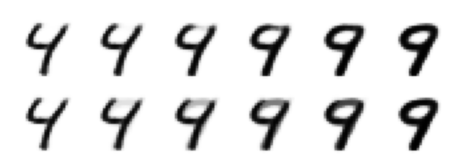

In [29]:
# interpolation results (change `interval` to control degree of interpolation)
interval = 5
raw_images = []
vae_images = []
for i in range(interval+1):
    recomb_enc = (1-(i/interval))*enc1 + (i/interval)*enc2
    recomb_img = vae.decode(recomb_enc).view(1, 1, 28, 28)
    vae_images.append(recomb_img)
    raw_recomb_img = (1-(i/interval))*rec_img1 + (i/interval)*rec_img2
    raw_images.append(raw_recomb_img.view(1, 1, 28, 28))
vae_showoff_img = torch.cat(vae_images, dim=3)
raw_showoff_img = torch.cat(raw_images, dim=3)
showoff_img = torch.cat([vae_showoff_img, raw_showoff_img], dim=2)
plt.imshow(showoff_img[0, 0].detach().cpu())
plt.axis('off')

Text(0.5, 1.0, 'PCA AT distribution of 4 and 9')

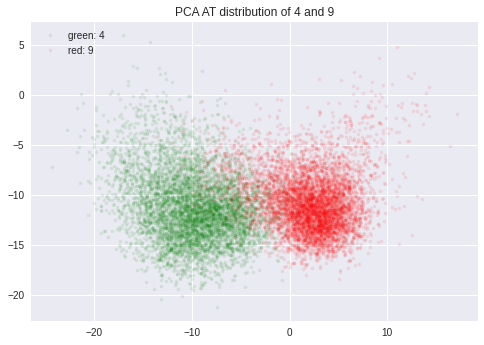

In [30]:
# for the digits in part 1/2, how does does the AT move...?
# First, we plot distributions for 0 and 1:
zero_data = pca.transform(digit_ats[tc[0]])
one_data = pca.transform(digit_ats[tc[1]])
plt.plot(zero_data[:, 0], zero_data[:, 1], "g.", alpha=0.1, label=f"green: {tc[0]}")
plt.plot(one_data[:, 0], one_data[:, 1], "r.", alpha=0.1, label=f"red: {tc[1]}")
plt.legend(loc="upper left")
plt.title(f"PCA AT distribution of {tc[0]} and {tc[1]}")

In [31]:
# Get interpolation AT trace through PCA
movement_tracker = np.zeros((0, digit_ats[0].shape[1]))
for i in range(21):
    recomb_enc = (1-(i/20.))*enc1 + (i/20.)*enc2
    recomb_img = vae.decode(recomb_enc)
    recomb_at = pca_classifier.up2lyr2(recomb_img)
    recomb_at = recomb_at.detach().cpu().numpy()
    recomb_at = recomb_at[:, ~rem_cols]
    movement_tracker = np.vstack([movement_tracker, recomb_at])
vae_pca_movement = pca.transform(movement_tracker)

# Next, plot AT movement as z is interpolated. 
# Recall that below plot is not of z, but PCA of AT. 
movement_tracker = np.zeros((0, digit_ats[0].shape[1]))
for i in range(21):
    recomb_img = (1-(i/20.))*rec_img1 + (i/20.)*rec_img2
    recomb_at = pca_classifier.up2lyr2(recomb_img.view(-1, 28**2))
    recomb_at = recomb_at.detach().cpu().numpy()
    recomb_at = recomb_at[:, ~rem_cols]
    movement_tracker = np.vstack([movement_tracker, recomb_at])
raw_pca_movement = pca.transform(movement_tracker)

/home/sungmin/Documents/dlTestGen/opensource-icse2020/osenv/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


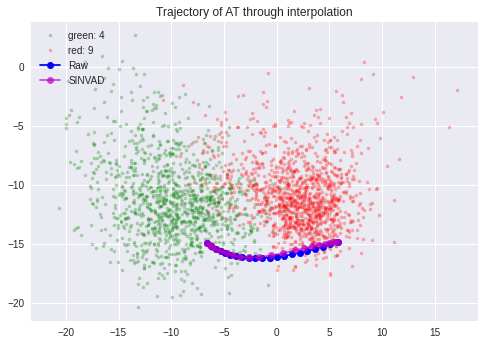

In [32]:
# Figure 5
red_zero_data = zero_data[np.random.binomial(1, 0.2, (zero_data.shape[0],)).astype(bool)]
red_one_data = one_data[np.random.binomial(1, 0.2, (one_data.shape[0],)).astype(bool)]

plt.plot(red_zero_data[:, 0], red_zero_data[:, 1], "g.", alpha=0.3, label=f"green: {tc[0]}")
plt.plot(red_one_data[:, 0], red_one_data[:, 1], "r.", alpha=0.3, label=f"red: {tc[1]}")
plt.plot(raw_pca_movement[:, 0], raw_pca_movement[:, 1], 'bo-', label='Raw')
plt.plot(vae_pca_movement[:, 0], vae_pca_movement[:, 1], 'mo-', alpha=0.7, label='SINVAD')
plt.title("Trajectory of AT through interpolation")
plt.legend(loc="upper left")